# Nettoyer un texte : des exercices pour découvrir l’approche bag-of-words
[Source](https://pythonds.linogaliana.fr/content/NLP/02_exoclean.html)

## Imports des librairies et des add-ons NLTK

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import base64
import string
import re
import nltk

from collections import Counter
from time import time

# from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

#!pip install pywaffle
from pywaffle import Waffle

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("genesis")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pault\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pault\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package genesis to
[nltk_data]     C:\Users\pault\AppData\Roaming\nltk_data...
[nltk_data]   Package genesis is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pault\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\pault\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
train = pd.read_csv("https://github.com/GU4243-ADS/spring2018-project1-ginnyqg/raw/master/data/spooky.csv")
train.columns = map(str.capitalize, train.columns) # Capitalize headings
# Remove id prefix from values, rename column ID and set it as index
train["Id"] = train["Id"].str.replace("id", "")
train = train.rename(columns={"Id": "ID"})
train = train.set_index("ID")

train

,Text,Author
ID,,
26305,"This process, however, afforded me no means of...",EAP
17569,It never once occurred to me that the fumbling...,HPL
11008,"In his left hand was a gold snuff box, from wh...",EAP
27763,How lovely is spring As we looked from Windsor...,MWS
12958,"Finding nothing else, not even gold, the Super...",HPL
...,...,...
17718,"I could have fancied, while I looked at it, th...",EAP
08973,The lids clenched themselves together as if in...,EAP
05267,"Mais il faut agir that is to say, a Frenchman ...",EAP


## Visualisation de la répartition des données
Les données sont déséquilibrées, on devra le prendre en compte lors de 

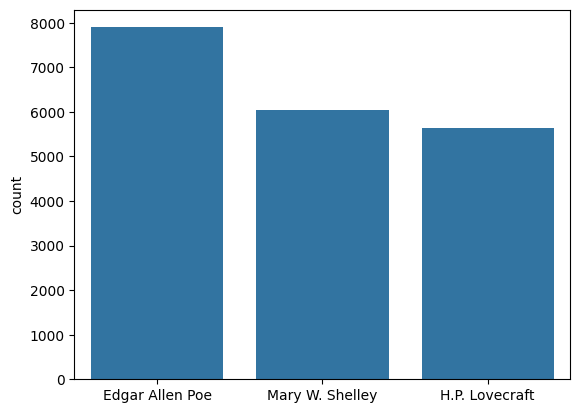

In [3]:
fig = plt.figure()
g = sns.barplot(
    x=["Edgar Allen Poe", "Mary W. Shelley", "H.P. Lovecraft"],
    y=train["Author"].value_counts(),
)

In [4]:
def build_dict(dict1, dict2):
    """
    Build a new dictionary with the values of dict1 as keys and the values of dict2 as values.

    Parameters:
    dict1 (dict): A dictionary with keys to be used as values in the new dictionary.
    dict2 (dict): A dictionary with values to be used as keys in the new dictionary.

    Returns:
    dict: A new dictionary with the values of dict1 as keys and the values of dict2 as values.
    """
    return {v1: v2 for k1, v1 in dict1.items() for k2, v2 in dict2.items() if k1 == k2}

C:\Users\pault\AppData\Local\Temp\ipykernel_9028\155964912.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  return fig.show()


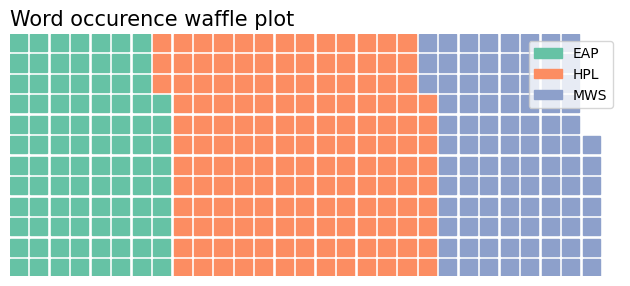

In [5]:
def count_words(df: pd.DataFrame, word_to_count: str) :
    df[f"word_count_{word_to_count}"] = df["Text"].apply(lambda x: x.count(word_to_count))
    # group the dataframe by author and sum the word counts
    word_counts_per_author = df.groupby('Author')[f"word_count_{word_to_count}"].sum().reset_index()
    word_counts_per_author = build_dict(word_counts_per_author.to_dict()["Author"], word_counts_per_author.to_dict()[f"word_count_{word_to_count}"])
    fig = plt.figure(
        FigureClass=Waffle,
        columns= 30,
        values=word_counts_per_author,
        title={
        'label': 'Word occurence waffle plot',
        'loc': 'left',
        'fontdict': {'fontsize': 15}
            },
        )
    return fig.show()
    
count_words(train, "dark")

## Nettoyage du texte

### Suppression de la ponctuation et des stopwords



In [6]:
train

,Text,Author,word_count_dark
ID,,,
26305,"This process, however, afforded me no means of...",EAP,0
17569,It never once occurred to me that the fumbling...,HPL,0
11008,"In his left hand was a gold snuff box, from wh...",EAP,0
27763,How lovely is spring As we looked from Windsor...,MWS,0
12958,"Finding nothing else, not even gold, the Super...",HPL,0
...,...,...,...
17718,"I could have fancied, while I looked at it, th...",EAP,0
08973,The lids clenched themselves together as if in...,EAP,0
05267,"Mais il faut agir that is to say, a Frenchman ...",EAP,0


In [7]:

stop_words = set(nltk.corpus.stopwords.words("english"))

print(stop_words)

def remove_punctuations_and_stopwords_nltk(text):
    tokens = nltk.tokenize.word_tokenize(text)
    no_punct_tokens = [token.lower() for token in tokens if (token not in stop_words) and token.isalpha()]
    return ' '.join(no_punct_tokens)

train['clean_text'] = train['Text'].apply(remove_punctuations_and_stopwords_nltk)

{'why', "needn't", "you'll", 'this', 'by', 'our', 'down', 'if', 'all', 'we', 'have', 'was', "don't", 'shan', 'what', 'her', 'ours', "hadn't", 'whom', 'the', 'into', 'further', 'out', 'him', 'does', 'o', 'with', 'only', 're', 'an', "it's", "aren't", 'is', 'not', 'been', 'it', 'on', 'than', 'while', 'weren', 'those', 'there', 'myself', 'mustn', 'my', 'couldn', "wasn't", "mightn't", "doesn't", 'most', 'had', 'no', 'am', "mustn't", 'he', 'because', 'd', 'his', 'be', 'doesn', 'before', 'above', "isn't", 'mightn', 'shouldn', 'to', 'haven', 'hers', 'such', 'and', 'me', 'has', 'll', "hasn't", 'now', 'here', 's', 'them', 'where', 've', 'did', "shouldn't", 'or', 'being', 'isn', 'too', "she's", 'which', "should've", 'doing', 'do', 'for', 'up', 'again', 'having', 'they', 'were', 'some', "that'll", 'herself', 'theirs', 'a', 'below', 'your', 'nor', 'won', "wouldn't", 'needn', 'own', 'm', 'few', 'off', "you'd", 'she', 'hasn', 'how', 'from', 'more', 'yourselves', 'at', 'then', 'but', 'other', 'in', 'w

## Visualisation avec un wordcloud

(-0.5, 399.5, 199.5, -0.5)

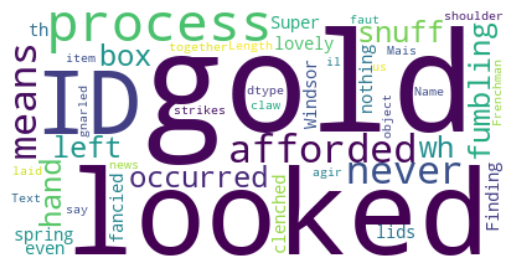

In [8]:
import wordcloud
import io
import requests
import PIL

img = "https://minio.lab.sspcloud.fr/lgaliana/generative-art/pythonds/book.png"
book_mask = np.array(PIL.Image.open(io.BytesIO(requests.get(img).content)))

def make_wordcloud(corpus):
    wc = wordcloud.WordCloud(
        background_color="white",
        #max_words=2000,
        #mask=book_mask,
        contour_width=3,
        contour_color="steelblue",
    )
    wc.generate(corpus)
    return wc


wordcloud_dumas = make_wordcloud(str(train['Text']))
plt.imshow(wordcloud_dumas, interpolation="bilinear")
plt.axis("off")

## Stemming and lemmatization with nltk and spacy


In [9]:
from nltk.stem import WordNetLemmatizer

nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pault\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\pault\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [10]:
lemm = WordNetLemmatizer()
eap_corpus = train[train['Author'] == "EAP"].reset_index().set_index("ID").sort_index()
eap_corpus_spacy = eap_corpus.copy()

In [11]:
def lemmatization(text):
    words = text.split()  # Split the text into individual word
    return " ".join([lemm.lemmatize(w) for w in words])

eap_corpus["Lemmatized_text"] = eap_corpus["Text"].apply(lemmatization)
eap_corpus

,Text,Author,word_count_dark,clean_text,Lemmatized_text
ID,,,,,
00003,"Above all, I burn to know the incidents of you...",EAP,1,above i burn know incidents passage dark valle...,"Above all, I burn to know the incident of your..."
00004,"He might see, perhaps, one or two points with ...",EAP,0,he might see perhaps one two points unusual cl...,"He might see, perhaps, one or two point with u..."
00006,"It was difficult, at any given time, to say wi...",EAP,0,it difficult given time say certainty upon two...,"It wa difficult, at any given time, to say wit..."
00007,"Now, it cannot be maintained, even, that by th...",EAP,0,now maintained even crawling system greatest a...,"Now, it cannot be maintained, even, that by th..."
00012,They had deposited me in the coffin.,EAP,0,they deposited coffin,They had deposited me in the coffin.
...,...,...,...,...,...
27956,why cause he talk about it in he sleep dat's h...,EAP,0,cause talk sleep dat i nose,why cause he talk about it in he sleep dat's h...
27957,Yet his reasons have not yet been matured into...,EAP,0,yet reasons yet matured expression,Yet his reason have not yet been matured into ...
27959,"He has been much admired by Mr. John Neal, and...",EAP,0,he much admired john neal great man small way,"He ha been much admired by Mr. John Neal, and ..."


### With Spacy

In [12]:
import spacy
sp = spacy.load('en_core_web_sm')

In [13]:
def lemmatization_spacy(text):
    text = sp(text)
    return " ".join([w.lemma_ for w in text])

eap_corpus_spacy["spacy_lemm"] = eap_corpus_spacy["Text"].apply(lemmatization_spacy)

In [14]:
eap_corpus_spacy

,Text,Author,word_count_dark,clean_text,spacy_lemm
ID,,,,,
00003,"Above all, I burn to know the incidents of you...",EAP,1,above i burn know incidents passage dark valle...,"above all , I burn to know the incident of you..."
00004,"He might see, perhaps, one or two points with ...",EAP,0,he might see perhaps one two points unusual cl...,"he might see , perhaps , one or two point with..."
00006,"It was difficult, at any given time, to say wi...",EAP,0,it difficult given time say certainty upon two...,"it be difficult , at any give time , to say wi..."
00007,"Now, it cannot be maintained, even, that by th...",EAP,0,now maintained even crawling system greatest a...,"now , it can not be maintain , even , that by ..."
00012,They had deposited me in the coffin.,EAP,0,they deposited coffin,they have deposit I in the coffin .
...,...,...,...,...,...
27956,why cause he talk about it in he sleep dat's h...,EAP,0,cause talk sleep dat i nose,why cause he talk about it in he sleep dat be ...
27957,Yet his reasons have not yet been matured into...,EAP,0,yet reasons yet matured expression,yet his reason have not yet be mature into exp...
27959,"He has been much admired by Mr. John Neal, and...",EAP,0,he much admired john neal great man small way,"he have be much admire by Mr. John Neal , and ..."


# TF-IDF: calcul de fréquence
[Source](https://www.analyticsvidhya.com/blog/2021/11/how-sklearns-tfidfvectorizer-calculates-tf-idf-values/)

In [27]:
train

,Text,Author,word_count_dark,clean_text
ID,,,,
26305,"This process, however, afforded me no means of...",EAP,0,this process however afforded means ascertaini...
17569,It never once occurred to me that the fumbling...,HPL,0,it never occurred fumbling might mere mistake
11008,"In his left hand was a gold snuff box, from wh...",EAP,0,in left hand gold snuff box capered hill cutti...
27763,How lovely is spring As we looked from Windsor...,MWS,0,how lovely spring as looked windsor terrace si...
12958,"Finding nothing else, not even gold, the Super...",HPL,0,finding nothing else even gold superintendent ...
...,...,...,...,...
17718,"I could have fancied, while I looked at it, th...",EAP,0,i could fancied i looked eminent landscape pai...
08973,The lids clenched themselves together as if in...,EAP,0,the lids clenched together spasm
05267,"Mais il faut agir that is to say, a Frenchman ...",EAP,0,mais il faut agir say frenchman never faints o...


In [37]:


tfidf = TfidfVectorizer()
tfs = tfidf.fit_transform(train["clean_text"], tfidf.get_feature_names_out).toarray()
    

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_transformer(text):
    words = str(text).split(" ")
    tfidf = TfidfVectorizer()
    tfs = tfidf.fit_transform(words, tfidf.get_feature_names_out).toarray()
    
    #print("Feature Names n",tfidf.get_feature_names_out())
    #print("Sparse Matrix n",tfs.shape,"n",tfs.toarray())    
    return tfidf, tfs, words

tfidf, tfs, words = tfidf_transformer(train["clean_text"])

tfidf


TfidfVectorizer()

In [38]:
tfs

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [63]:
tfidf_df = pd.DataFrame(tfs, columns=tfidf.get_feature_names_out())
tfidf_df

,aaem,ab,aback,abaft,abandon,abandoned,abandoning,abandonment,abaout,abased,...,æmilianus,æneid,ærial,æronaut,æronauts,ærostation,æschylus,élite,émeutes,οἶδα
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.253504,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19574,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19575,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19576,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19577,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
if [tfidf_df['abandon'] != 0.0] :
    top_50_values = tfidf_df['abandon'].nlargest(50)
    
print(top_50_values)

9560     0.386052
16516    0.385609
18251    0.383920
9013     0.369402
12189    0.367765
18126    0.348445
18019    0.326612
5694     0.306675
839      0.285886
13666    0.232780
215      0.232553
0        0.000000
1        0.000000
2        0.000000
3        0.000000
4        0.000000
5        0.000000
6        0.000000
7        0.000000
8        0.000000
9        0.000000
10       0.000000
11       0.000000
12       0.000000
13       0.000000
14       0.000000
15       0.000000
16       0.000000
17       0.000000
18       0.000000
19       0.000000
20       0.000000
21       0.000000
22       0.000000
23       0.000000
24       0.000000
25       0.000000
26       0.000000
27       0.000000
28       0.000000
29       0.000000
30       0.000000
31       0.000000
32       0.000000
33       0.000000
34       0.000000
35       0.000000
36       0.000000
37       0.000000
38       0.000000
Name: abandon, dtype: float64


## Approche contextuelle avec les n-grams



In [71]:
nltk.download("genesis")
nltk.corpus.genesis.words("english-web.txt")

[nltk_data] Downloading package genesis to
[nltk_data]     C:\Users\pault\AppData\Roaming\nltk_data...
[nltk_data]   Package genesis is already up-to-date!


['In', 'the', 'beginning', 'God', 'created', 'the', ...]

In [72]:
eap_clean = train[train["Author"] == "EAP"]
eap_clean = " ".join(eap_clean["Text"])
tokens = eap_clean.split()
print(tokens[:10])
text = nltk.Text(tokens)
print(text)

['This', 'process,', 'however,', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the']
<Text: This process, however, afforded me no means of...>


In [75]:
text.concordance("fear")

Displaying 13 of 13 matches:
d quick unequal spoken apparently in fear as well as in anger. What he said wa
hutters were close fastened, through fear of robbers, and so I knew that he co
to details. I even went so far as to fear that, as I occasioned much trouble, 
years of age, was heard to express a fear "that she should never see Marie aga
ich must be entirely remodelled, for fear of serious accident I mean the steel
 my arm, and I attended her home. 'I fear that I shall never see Marie again.'
clusion here is absurd. "I very much fear it is so," replied Monsieur Maillard
bt of ultimately seeing the Pole. "I fear you are right there," said the Prefe
er occurred before.' Indeed I had no fear on her account. For a moment there w
erhaps so," said I; "but, Legrand, I fear you are no artist. It is my firm int
 raps with a hammer. Be of heart and fear nothing. My daughter, Mademoiselle M
e splendor. I have not the slightest fear for the result. The face was so far 
arriers of iron that he

In [82]:
from nltk.collocations import BigramCollocationFinder
from nltk.metrics.association import BigramAssocMeasures

bgm = BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(text)
scored = finder.score_ngrams(bgm.likelihood_ratio)
scored

[(('of', 'the'), 5394.633161623189),
 (('in', 'the'), 1861.8040314500636),
 (('had', 'been'), 1672.8479482773757),
 (('to', 'be'), 1579.2572972495727),
 (('have', 'been'), 1567.0229481626936),
 (('I', 'had'), 1050.358187965522),
 (('It', 'was'), 964.6372600802067),
 (('it', 'is'), 922.7065830644472),
 (('could', 'not'), 885.1957598707793),
 (('from', 'the'), 872.7994140751337),
 (('upon', 'the'), 865.4865695126989),
 (('more', 'than'), 813.2761404881928),
 (('it', 'was'), 803.3593178017125),
 (('would', 'have'), 779.1131093101981),
 (('with', 'a'), 722.010100768968),
 (('did', 'not'), 701.5397007598245),
 (('I', 'am'), 686.0537473863642),
 (('the', 'a'), 642.2647484572077),
 (('at', 'once'), 621.3273760779734),
 (('might', 'have'), 609.8268950209949),
 (('I', 'could'), 605.3470577375153),
 (('at', 'length'), 593.6304359342281),
 (('to', 'the'), 587.1434338897498),
 (('the', 'most'), 558.8944943225443),
 (('has', 'been'), 538.2128104653315),
 (('I', 'have'), 534.5403543941378),
 (('of',